<a href="https://colab.research.google.com/github/Kushagra-1/Time-Series-Prediction-LSTMs-/blob/main/predictionLSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
import pandas as pd
import requests
import json

def fetch_daily_data(symbol):
    pair_split = symbol.split('/')  # symbol must be in format XXX/XXX ie. BTC/EUR
    symbol = pair_split[0] + '-' + pair_split[1]
    url = f'https://api.pro.coinbase.com/products/{symbol}/candles?granularity=86400'
    response = requests.get(url)
    if response.status_code == 200:  # check to make sure the response from server is good
        data = pd.DataFrame(json.loads(response.text), columns=['unix', 'low', 'high', 'open', 'close', 'volume'])
        data['date'] = pd.to_datetime(data['unix'], unit='s')  # convert to a readable date
        data['vol_fiat'] = data['volume'] * data['close']      # multiply the BTC volume by closing price to approximate fiat volume

        # if we failed to get any data, print an error...otherwise write the file
        if data is None:
            print("Did not return any data from Coinbase for this symbol")
        else:
            data.to_csv(f'Coinbase_{pair_split[0] + pair_split[1]}_dailydata.csv', index=False)

    else:
        print("Did not receieve OK response from Coinbase API")


if __name__ == "__main__":
    # we set which pair we want to retrieve data for
    pair = "ETH/USD"
    fetch_daily_data(symbol=pair)

In [135]:
df = pd.read_csv("/content/Coinbase_ETHUSD_dailydata.csv") 
df.head()


,unix,low,high,open,close,volume,date,vol_fiat
0,1633392000,3365.34,3481.00,3386.90,3468.17,110835.093476,2021-10-05,3.843949e+08
1,1633305600,3269.67,3438.91,3419.63,3387.20,163829.626778,2021-10-04,5.549237e+08
2,1633219200,3343.36,3489.18,3388.67,3420.07,124271.048646,2021-10-03,4.250157e+08
3,1633132800,3258.94,3469.95,3311.20,3387.82,144778.384500,2021-10-02,4.904831e+08
4,1633046400,2967.41,3337.15,3001.14,3311.16,201035.513451,2021-10-01,6.656608e+08


In [136]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

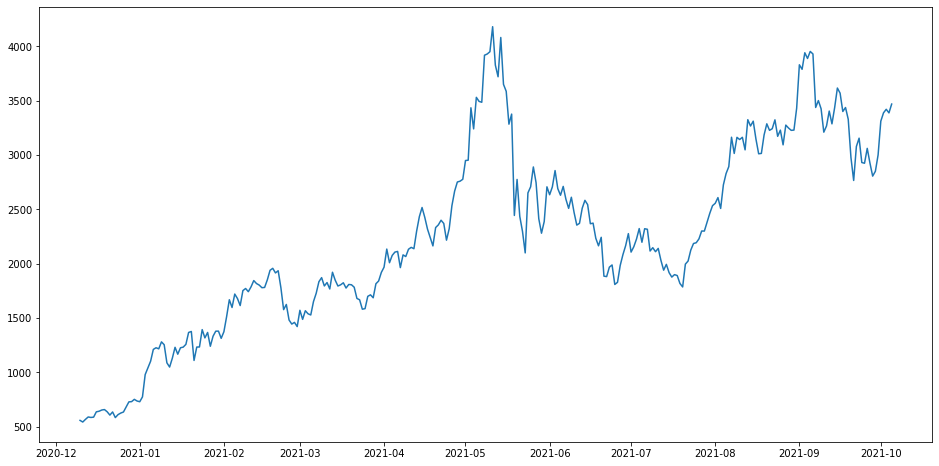

In [137]:
#setting index as date
df['date'] = pd.to_datetime(df.date,format='%Y-%m-%d')
df.index = df['date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['close'], label='Close Price history')

In [138]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'close'])
for i in range(0,len(data)):
    new_data['date'][i] = data['date'][i]
    new_data['close'][i] = data['close'][i]

#setting index
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:187,:]
valid = dataset[187:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [182]:
num_units = 30
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 5
num_epochs = 100

# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = num_units, activation = activation_function, input_shape=(None, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = optimizer, loss = loss_function)

# Using the training set to train the model
regressor.fit(x_train, y_train, batch_size = batch_size, epochs = num_epochs)

inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

Epoch 1/100
26/26 [==============================] - 2s 18ms/step - loss: 0.0500
Epoch 2/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0303
Epoch 3/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0305
Epoch 4/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0291
Epoch 5/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0274
Epoch 6/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0266
Epoch 7/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0259
Epoch 8/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0245
Epoch 9/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0232
Epoch 10/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0237
Epoch 11/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0209
Epoch 12/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0198
Epoch 13/100
26/26 [=====

In [183]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = regressor.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [184]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

close          158.328012
Predictions     44.245974
dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


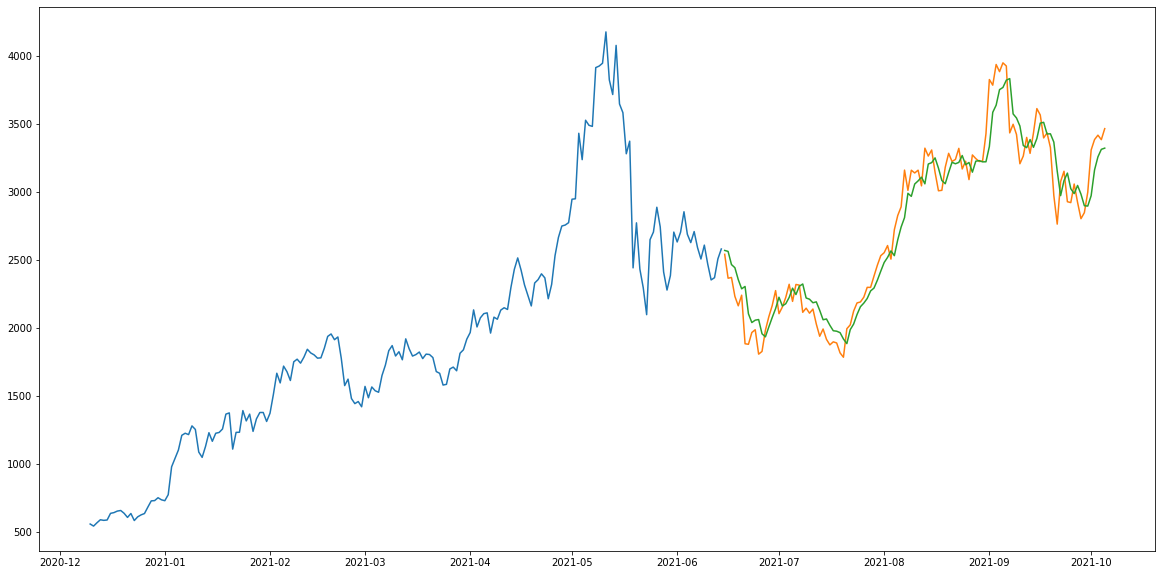

In [181]:
#for plotting
train = new_data[:187]
valid = new_data[187:]
valid['Predictions'] = closing_price
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])